In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

In [2]:
def GBM_exact(T, K, S, sigma, r, M):
    S_all = []
    S_all.append(S)
    dt = T/M
    Z_all = []
    for i in range(M-1):
        Zm = np.random.normal()
        Z_all.append(Zm)
        S_all.append(S_all[i] * np.exp((r-0.5*sigma**2) * dt + sigma * np.sqrt(dt) * Zm)) 
    return S_all, Z_all

In [3]:
def GBM_Euler(T, K, S, sigma, r, M, Z_all = None):
    S_all = []
    S_all.append(S)
    dt = T/M
    for i in range(M-1):
        if Z_all:
            Zm = Z_all[i]
        else:
            Zm = np.random.normal()
        S_all.append(S_all[i] + r* S_all[i] * dt + sigma * S_all[i] * np.sqrt(dt) * Zm) 
    return S_all

In [4]:
T = 1
K = 99
S = 100
sigma = 0.2
r = 0.06

In [25]:
M=365
s_all = [GBM_Euler(T, K, S, sigma, r, M) for x in range(1000)]
s_all_exact = [GBM_exact(T, K, S, sigma, r, M)[0] for x in range(1000)]

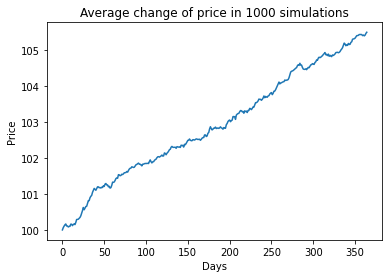

In [27]:
arrays = [np.array(x) for x in s_all]
plt.plot([np.mean(k) for k in zip(*arrays)])
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Average change of price in 1000 simulations')
plt.savefig("figures/average_change.pdf", dpi=300)

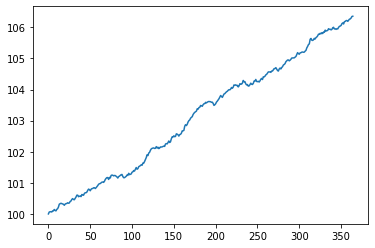

In [19]:
arrays = [np.array(x) for x in s_all_exact]
plt.plot([np.mean(k) for k in zip(*arrays)])

In [20]:
s_all_exact, Z_all = GBM_exact(T, K, S, sigma, r, M)
s_all = GBM_Euler(T, K, S, sigma, r, M, Z_all)

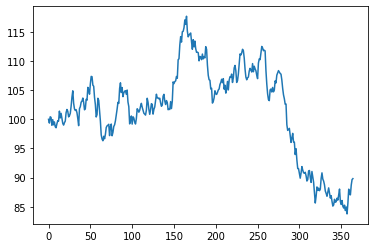

In [21]:
plt.plot(s_all_exact)

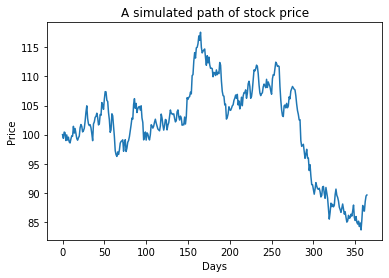

In [23]:
plt.plot(s_all)
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('A simulated path of stock price')
plt.savefig("figures/single_path.pdf", dpi=300)


In [2]:
def get_delta(S, K, r, sigma, tau):
    d1 = (math.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * math.sqrt(tau))
    return norm.cdf(d1)

def adjust_hedge(portfolio, delta, S):
    portfolio['stocks'] = delta

def simulate_hedge(T, K, S, sigma, delta_sigma, r, M, adjust_freq, Z_all = None):
    # setup
    S_all = []
    S_all.append(S)
    delta_all = []
    dt = T/M
    tau = T
    
    ratio = round(M/adjust_freq)
    portfolio = {}
    portfolio['stocks'] = get_delta(S, K, r, delta_sigma, tau)
    delta_all.append(portfolio['stocks'])
    
    # run the hedging simulation
    for i in range(M-1):
        if Z_all:
            Zm = Z_all[i]
        else:
            Zm = np.random.normal()
        S_all.append(S_all[i] + r* S_all[i] * dt + sigma * S_all[i] * np.sqrt(dt) * Zm) 
        tau -= dt
        
        if i % ratio == 0 and i > 0:
            delta = get_delta(S_all[-1], K, r, delta_sigma, tau)
            adjust_hedge(portfolio, delta, S_all[-1])
            delta_all.append(portfolio['stocks'])
    return delta_all
    

In [3]:
T = 1
K = 99
S = 100
sigma = 0.2
delta_sigma = 0.2
r = 0.06
M=365
adjust_freq= 52

In [4]:
delta_M52 = [simulate_hedge(T, K, S, sigma, delta_sigma, r, M, adjust_freq) for x in range(100)]
delta_bigger_M52 = [simulate_hedge(T, K, S, sigma, 0.5, r, M, adjust_freq) for x in range(100)]
delta_smaller_M52 = [simulate_hedge(T, K, S, sigma, 0.05, r, M, adjust_freq) for x in range(100)]

In [5]:
arrays_M52 = [np.array(x) for x in delta_M52]

In [6]:
T = 1
K = 99
S = 100
sigma = 0.2
delta_sigma = 0.2
r = 0.06
M=365
adjust_freq = M

In [7]:
delta= [simulate_hedge(T, K, S, sigma, delta_sigma, r, M, adjust_freq) for x in range(100)]
delta_bigger = [simulate_hedge(T, K, S, sigma, 0.5, r, M, adjust_freq) for x in range(100)]
delta_smaller = [simulate_hedge(T, K, S, sigma, 0.05, r, M, adjust_freq) for x in range(100)]

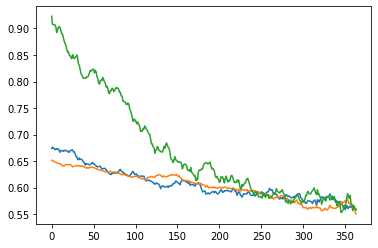

In [8]:
arrays = [np.array(x) for x in delta]
plt.plot([np.mean(k) for k in zip(*arrays)])

arrays_dbig = [np.array(x) for x in delta_bigger]
plt.plot([np.mean(k) for k in zip(*arrays_dbig)])

arrays_dsmall = [np.array(x) for x in delta_smaller]
plt.plot([np.mean(k) for k in zip(*arrays_dsmall)])

In [9]:
delta_0 = []
delta_10 = []
delta_50 = []
delta_T = []
for ar in arrays:
    delta_0.append(ar[0])
    delta_10.append(ar[10])
    delta_50.append(ar[50])
    delta_T.append(ar[-1])

(array([ 0.9314846 ,  0.        ,  1.8629692 ,  0.9314846 ,  8.38336141,
         8.38336141, 16.76672283,  4.65742301,  2.7944538 ,  1.8629692 ]),
 array([-0.1427067 , -0.1212356 , -0.0997645 , -0.0782934 , -0.0568223 ,
        -0.0353512 , -0.0138801 ,  0.007591  ,  0.02906211,  0.05053321,
         0.07200431]),
 <BarContainer object of 10 artists>)

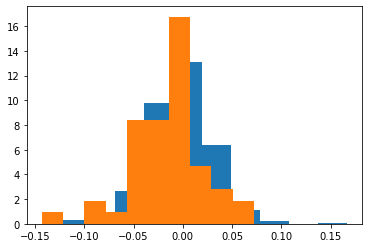

In [10]:
# distribution of delta differences
plt.hist([arrays[0][i+1] - arrays[0][i] for i in range(len(arrays[0]) - 2)], density=True)
plt.hist([arrays_M52[0][i+1] - arrays_M52[0][i] for i in range(len(arrays_M52[0]) - 2)], density=True)

(array([1.52250242e-03, 4.56750726e-03, 1.06575169e-02, 7.15576137e-02,
        1.22409195e+00, 5.87685934e+00, 5.34398349e-01, 2.89275460e-02,
        1.06575169e-02, 1.52250242e-03]),
 array([-0.6943563 , -0.56556935, -0.43678241, -0.30799547, -0.17920853,
        -0.05042158,  0.07836536,  0.2071523 ,  0.33593924,  0.46472618,
         0.59351313]),
 <BarContainer object of 10 artists>)

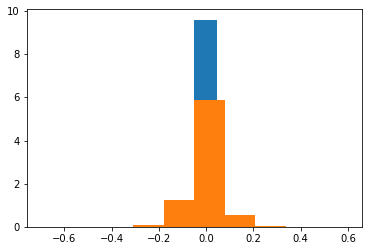

In [12]:
diffs = []
for run in arrays:
    for i in range(len(run) - 1):
        diffs.append(run[i+1] - run[i])
diffs_52 = []
for run in arrays_M52:
    for i in range(len(run) - 1):
        diffs_52.append(run[i+1] - run[i])
        
plt.hist(diffs, density=True)
plt.hist(diffs_52, density=True)

In [13]:
import seaborn as sns

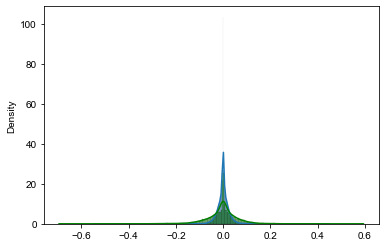

In [14]:
g=sns.histplot(diffs, stat='density', kde=True)
g=sns.histplot(diffs_52, color='green', stat='density', kde=True)
sns.set(rc = {'figure.figsize':(20,8)})

<AxesSubplot:ylabel='Density'>

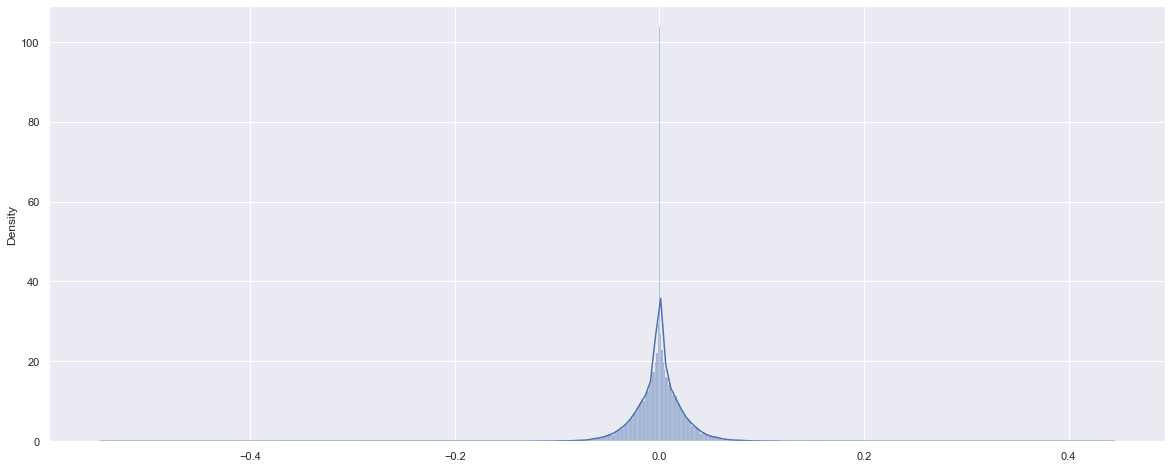

In [15]:
sns.histplot(diffs, stat='density', kde=True)

<AxesSubplot:ylabel='Density'>

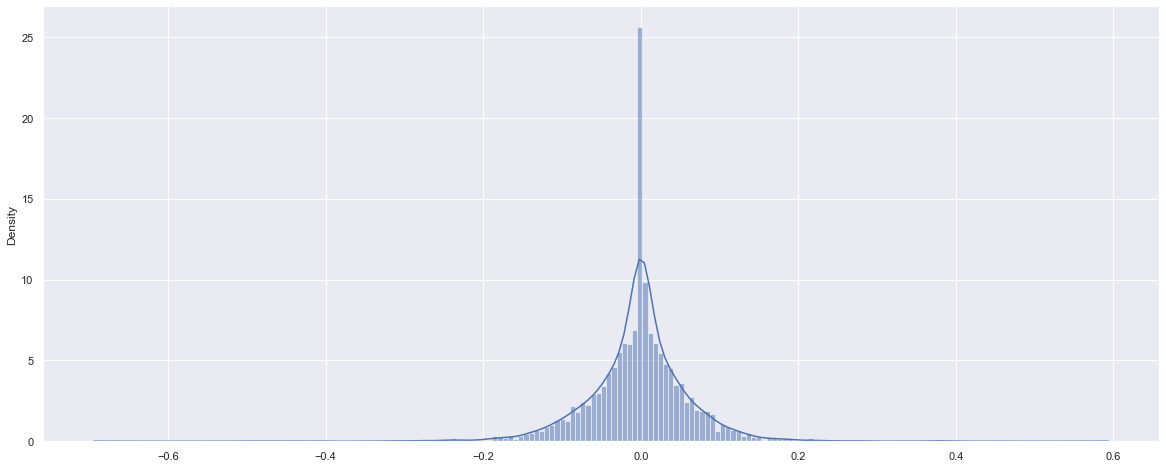

In [16]:
sns.histplot(diffs_52, stat='density', kde=True)

(array([ 1.,  0.,  2.,  1.,  9.,  9., 18.,  5.,  3.,  2.]),
 array([-0.1427067 , -0.1212356 , -0.0997645 , -0.0782934 , -0.0568223 ,
        -0.0353512 , -0.0138801 ,  0.007591  ,  0.02906211,  0.05053321,
         0.07200431]),
 <BarContainer object of 10 artists>)

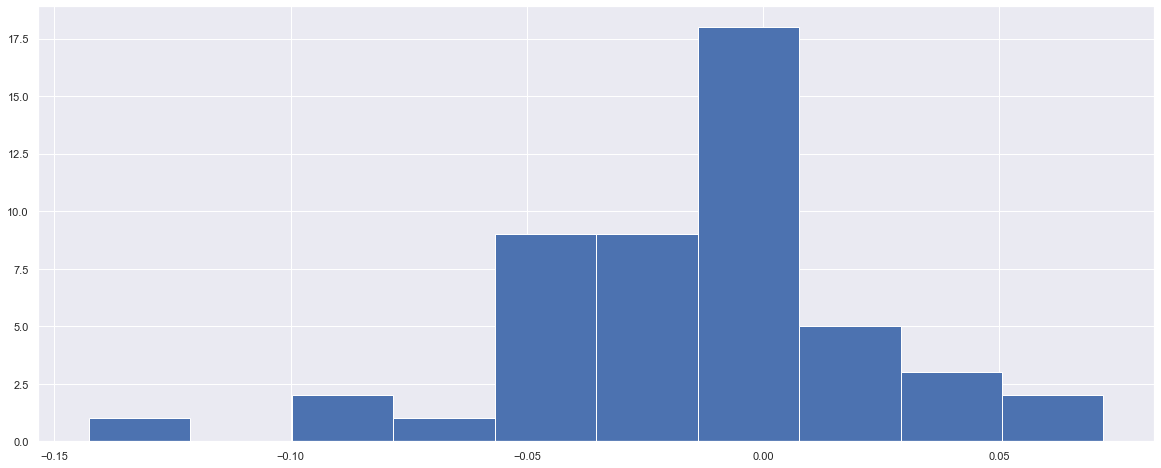

In [17]:
plt.hist([arrays_M52[0][i+1] - arrays_M52[0][i] for i in range(len(arrays_M52[0]) - 2)])

In [ ]:
plt.hist(delta_0)

In [ ]:
plt.hist(delta_10)

In [ ]:
plt.hist(delta_50)

In [ ]:
plt.hist(delta_T)

In [ ]:
np.mean(arrays[-1])

In [ ]:
delta_0 = [k[0] for k in zip(*arrays)]
delta_0 = [k[-1] for k in zip(*arrays)]

In [ ]:
T = 1
K = 99
S = 100
sigma = 0.2
delta_sigma = 0.2
r = 0.06
M=365
adjust_freq = M

In [ ]:
delta= [simulate_hedge(T, K, S, sigma, delta_sigma, r, M, 52) for x in range(100)]
delta_daily= [simulate_hedge(T, K, S, sigma, delta_sigma, r, M, adjust_freq) for x in range(100)]

In [ ]:
arrays = [np.array(x) for x in delta]
plt.plot( np.linspace(0,365,52), [np.mean(k) for k in zip(*arrays)])

arrays = [np.array(x) for x in delta_daily]
plt.plot([np.mean(k) for k in zip(*arrays)])

In [28]:
def get_delta(S, K, r, sigma, tau):
    d1 = (math.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * math.sqrt(tau))
    return norm.cdf(d1)

def adjust_hedge(portfolio, delta, S, tau):
    if portfolio['stocks'] < delta:
        portfolio['payback'] += (delta - portfolio['stocks']) * S * math.e**(r*tau)
        portfolio['stocks'] = delta
    else:
        portfolio['payback'] -= (portfolio['stocks']-delta) * S * math.e**(r*tau)
        portfolio['stocks'] = delta

    
def Black_Scholes_Call(S, K, r, vol, tau):
    d1 = (np.log(S / K) + (r + ((vol**2)/2.)*tau)) / (vol*np.sqrt(tau))
    d2 = d1 - vol*np.sqrt(tau)

    V = S * norm.cdf(d1) - np.exp(-r*tau) * K * norm.cdf(d2)
    
    return V, norm.cdf(d1)
    
    
def simulate_hedge(T, K, S, sigma, delta_sigma, r, M, adjust_freq, Z_all = None):
    # setup
    S_all = []
    S_all.append(S)
    delta_all = []
    dt = T/M
    tau = T
    ratio = M/adjust_freq
    
    portfolio = {}
    portfolio['stocks'] = get_delta(S, K, r, delta_sigma, tau)
    portfolio['call'] = -1
    initial_loan = S * portfolio['stocks'] - Black_Scholes_Call(S, K, r, delta_sigma, tau)[0]
    portfolio['money'] = 0
    portfolio['payback'] = initial_loan*math.e**(r*tau)
    delta_all.append(portfolio['stocks'])
    # run the hedging simulation
    for i in range(M-1):
        if Z_all:
            Zm = Z_all[i]
        else:
            Zm = np.random.normal()
        S_all.append(S_all[i] + r* S_all[i] * dt + sigma * S_all[i] * np.sqrt(dt) * Zm) 
        tau -= dt
        
        if i % ratio == 0 and i>0: 
            delta = get_delta(S_all[-1], K, r, delta_sigma, tau)
            adjust_hedge(portfolio, delta, S_all[-1], tau)
            delta_all.append(portfolio['stocks'])
        
    # call gets excercised
    if S_all[-1] > K:
        portfolio['money'] -= (1 - portfolio['stocks']) * S_all[-1]
        portfolio['money'] += K 
        portfolio['stocks'] = 0
        portfolio['call'] = 0
    else:
        portfolio['money'] += portfolio['stocks'] * S_all[-1]
        portfolio['stocks'] = 0
        portfolio['call'] = 0
        
    portfolio['money'] -= portfolio['payback']

    return portfolio['money']

In [29]:
T = 1
K = 99
S = 100
sigma = 0.2
delta_sigma = 0.2
r = 0.06
M=365
adjust_freq = M

In [30]:
simulate_hedge(T, K, S, sigma, delta_sigma, r, M, adjust_freq)

0.44809774712760075

In [31]:
all_money = [simulate_hedge(T, K, S, sigma, delta_sigma, r, M, adjust_freq) for x in range(500)]

0.01621573950588355


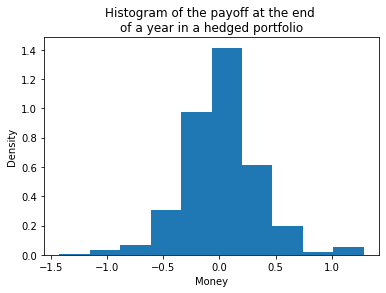

In [48]:
print(np.mean(all_money))
plt.hist(all_money, density=True)
plt.xlabel("Money")
plt.ylabel("Density")
plt.title("Histogram of the payoff at the end \nof a year in a hedged portfolio")
plt.savefig("figures/hist_normal.pdf", dpi=300)

In [33]:
import scipy.stats as sts

sts.ttest_1samp(all_money,0)

Ttest_1sampResult(statistic=1.0895150168308112, pvalue=0.27645270629687546)

In [37]:
# difference in hedging updates
T = 1
K = 99
S = 100
sigma = 0.2
delta_sigma = 0.2
r = 0.06
M=365
adjust_freq = 52

all_money_lowadjust = [simulate_hedge(T, K, S, sigma, delta_sigma, r, M, adjust_freq) for x in range(500)]

0.0698739606162161


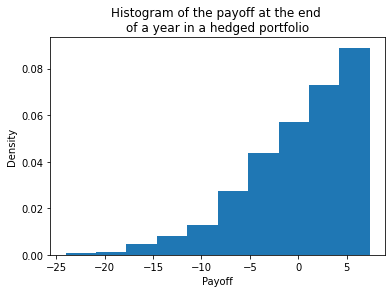

In [52]:
print(np.mean(all_money_lowadjust))
plt.hist(all_money_lowadjust, density=True)
plt.xlabel("Payoff")
plt.ylabel("Density")
plt.title("Histogram of the payoff at the end \nof a year in a hedged portfolio")
plt.savefig("figures/hedge_lowadjust.pdf", dpi=300)

In [41]:
sts.ttest_ind(all_money_lowadjust,all_money)

Ttest_indResult(statistic=0.21394907651605402, pvalue=0.8306304707107655)

In [53]:
# market more volatile than expected
T = 1
K = 99
S = 100
sigma = 0.3
delta_sigma = 0.2
r = 0.06
M=365
adjust_freq = M

all_money_highvol = [simulate_hedge(T, K, S, sigma, delta_sigma, r, M, adjust_freq) for x in range(500)]

-3.763042765970268


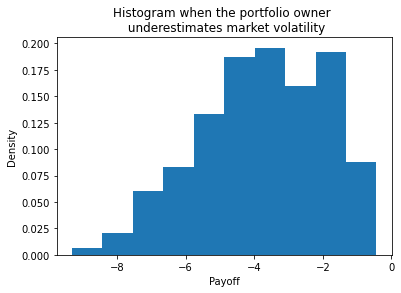

In [72]:
print(np.mean(all_money_highvol))
plt.hist(all_money_highvol, density=True)
plt.xlabel("Payoff")
plt.ylabel("Density")
plt.title("Histogram when the portfolio owner \n underestimates market volatility")
plt.savefig("figures/hedge_highvol.pdf", dpi=300)


In [55]:
# market less volatile than expected
T = 1
K = 99
S = 100
sigma = 0.1
delta_sigma = 0.2
r = 0.06
M=365
adjust_freq = M

all_money_lowvol = [simulate_hedge(T, K, S, sigma, delta_sigma, r, M, adjust_freq) for x in range(500)]

3.6467326768341093


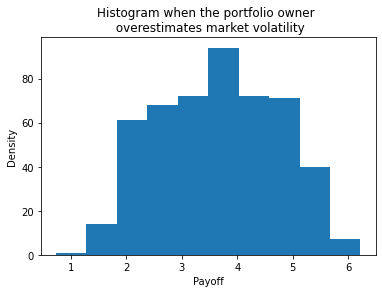

In [73]:
print(np.mean(all_money_lowvol))
plt.hist(all_money_lowvol)
plt.xlabel("Payoff")
plt.ylabel("Density")
plt.title("Histogram when the portfolio owner \n overestimates market volatility")
plt.savefig("figures/hedge_lowvol.pdf", dpi=300)

In [66]:
print(sts.ttest_ind(all_money_lowvol,all_money))
print(sts.ttest_ind(all_money_lowvol,all_money_highvol))
print(sts.ttest_ind(all_money_lowvol,all_money_highvol))

Ttest_indResult(statistic=72.11260449854065, pvalue=0.0)
Ttest_indResult(statistic=78.18814441014781, pvalue=0.0)
Ttest_indResult(statistic=78.18814441014781, pvalue=0.0)


In [ ]:
#TODO
# run multiple simulations and measure distribution of delta at several time points (e.g. t=0, t=10, t=T)
# done

In [ ]:
# distribution of delta differences